# **Use MSTR Data**

# **HMM**
Dataset used include
coinbase_premium_gap getting from CryptoQuant and OHLCV data getting from Alphavantage, hourly data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load data
df = pd.read_csv("/content/mstr_full_market_data_with_indicators.csv", parse_dates=["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

# 1. Create cyclical time features
df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour/24)
df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour/24)

# 2. Select all numerical features for PCA
# Exclude datetime and any other non-numerical columns
features = [
    'coinbase_premium_gap',
    'coinbase_premium_gap_usdt_adjusted',
    'coinbase_premium_index',
    'coinbase_premium_index_usdt_adjusted',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'sma',
    'rsi',
    'hour_sin',
    'hour_cos'  # our transformed time features
]

# 3. Standardize the features (important for PCA)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Impute NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
scaled_features = imputer.fit_transform(scaled_features) # Impute NaN values

# 4. Perform PCA
# Choose number of components (can adjust this)
n_components = min(4, len(features))
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_features)

# 5. Create DataFrame with the principal components
pca_df = pd.DataFrame(
    data=principal_components,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

def select_top_features_via_pca(df, features, n_components=4, top_n=6):
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='mean')
    scaled = scaler.fit_transform(df[features])
    scaled = imputer.fit_transform(scaled)

    pca = PCA(n_components=n_components)
    pca.fit(scaled)

    loadings = np.abs(pca.components_.T)
    feature_importance = pd.Series(loadings.sum(axis=1), index=features)
    top_features = feature_importance.sort_values(ascending=False).head(top_n).index.tolist()
    return df[top_features]

# 6. Optionally: Combine with original data
final_df = pd.concat([df, pca_df], axis=1)

# 7. Examine explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.39614273 0.19598204 0.11537089 0.11330038]
Total explained variance: 0.8207960314312756


In [ ]:
loadings = pca.components_

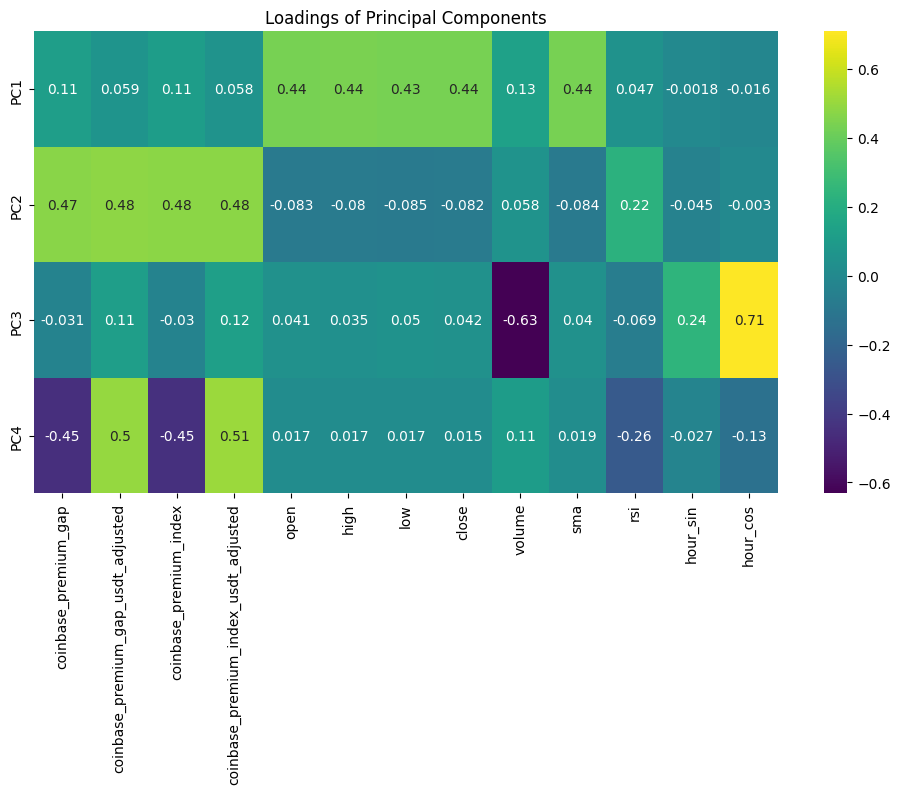

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=features, index=[f'PC{i+1}' for i in range(n_components)])

# Plot a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(loadings_df, annot=True, cmap='viridis')
plt.title('Loadings of Principal Components')
plt.show()

# **HMM**

In [ ]:
pip install hmmlearn

In [ ]:
from hmmlearn import hmm
from xgboost import XGBClassifier

X_selected = select_top_features_via_pca(df, features, n_components=4, top_n=6)

# Train HMM to predict market regimes
scaler = StandardScaler()
# hmm_features = ["coinbase_premium_gap_usdt_adjusted", "coinbase_premium_index_usdt_adjusted", "open", "high", "low", "close", "returns", "volume","sma","hour_cos"]
# Assuming X_selected was originally derived from df
common_index = df.index.intersection(X_selected.index)

# Filter both DataFrames to the common index
X_selected = X_selected.loc[common_index]
df = df.loc[common_index]

# Now apply the rest of your logic
scaled = scaler.fit_transform(X_selected)
model_hmm = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
model_hmm.fit(scaled)
df["hmm_state"] = model_hmm.predict(scaled)  # Add HMM states as a feature


# **Rolling Window Selection Before LSTM**
LSTM Window Size Selection Pipeline

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# ======= Helper Functions ======= #
# Removed features here to prevent collision
def create_sequences(data, window_size=60):
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i, :-1])  # all except target
        y.append(data[i, -1])  # target = close price
    return np.array(x), np.array(y)

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Predict 1 output
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_window_size(df, features, target_col='close', window_sizes=[30, 45, 60]):
    results = []

    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])

    # Append target column at the end
    target_scaled = scaler.fit_transform(df[[target_col]])
    scaled_data = np.hstack((scaled_data, target_scaled))

    for window in window_sizes:
        try:
            X, y = create_sequences(scaled_data, window_size=window)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

            model = build_lstm((X_train.shape[1], X_train.shape[2]))
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            results.append((window, mse))

            print(f"Window Size: {window} | MSE: {mse:.6f}")
        except Exception as e:
            print(f"Window Size {window} failed: {e}")

    # Select the best window
    best_window, best_mse = min(results, key=lambda x: x[1])
    print(f"\n✅ Best window size: {best_window} (MSE: {best_mse:.6f})")

    return best_window, results

# ======= Main Code ======= #

df["returns"] = df["close"].pct_change()
df = df.dropna()

# Select features (example)
# Fixed feature list, added comma between 'hmm_state' and next feature
features = ["hmm_state","coinbase_premium_gap", "coinbase_premium_index","coinbase_premium_gap_usdt_adjusted", "coinbase_premium_index_usdt_adjusted",
            "open", "high", "low", "close", "volume", "rsi", "sma"]

# Run pipeline
best_window, all_results = evaluate_window_size(df, features, target_col="close", window_sizes=[30, 45, 60])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Window Size: 30 | MSE: 0.005812


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Window Size: 45 | MSE: 0.008784


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Window Size: 60 | MSE: 0.007403

✅ Best window size: 30 (MSE: 0.005812)


# **Feature Selection for LSTM**
Use XGBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# Full feature list
features = ["hmm_state", "coinbase_premium_gap", "coinbase_premium_index", "coinbase_premium_gap_usdt_adjusted", "coinbase_premium_index_usdt_adjusted",
            "open", "high", "low", "close", "volume", "rsi", "sma"]

target = "close"

# Scale data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_target = scaler.fit_transform(df[[target]])

# Split before LSTM (no sequence yet)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, shuffle=False)

# Step 1: Feature selection using XGBoost
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, y_train)

# Select features based on importance threshold
selector = SelectFromModel(xgb, threshold="median", prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


# Get selected feature names
selected_mask = selector.get_support()
selected_features = [f for f, s in zip(features, selected_mask) if s]

print("✅ Selected features:", selected_features)


✅ Selected features: ['coinbase_premium_gap', 'open', 'high', 'low', 'close', 'sma']


# **Train LSTM**


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Scaling the data using MinMaxScaler for LSTM (LSTM is sensitive to scaling)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[selected_features])

# Create sequences (look back window)
def create_sequences(data, best_window):
    x = []
    y = []
    for i in range(best_window, len(data)):
        x.append(data[i-best_window:i, :-1])  # Use all features except the target (close price)
        y.append(data[i, -1])  # Predict the next close price
    return np.array(x), np.array(y)

# Create sequences
X, y = create_sequences(scaled_data, best_window)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape the data for LSTM: (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# To prevent overfitting


In [ ]:
from tensorflow.keras import regularizers

# Build the LSTM model with regularization
model = Sequential()

# LSTM Layer with Dropout for regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))) # L2 Regularization
model.add(Dropout(0.2))

# LSTM Layer
model.add(LSTM(units=100, return_sequences=False,
               kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)))  # L2 Regularization
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))  # Predicting next close price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - loss: 7.3320e-04 - val_loss: 0.0080
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 7.6140e-04 - val_loss: 0.0065
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 7.0524e-04 - val_loss: 0.0046
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 6.5405e-04 - val_loss: 0.0041
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 7.1782e-04 - val_loss: 0.0145
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 6.7716e-04 - val_loss: 0.0054
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 6.3440e-04 - val_loss: 0.0062
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 6.3462e-04 - val_loss: 0.0110
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 6.2055e-04 - val_loss: 0.0093
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 6.4314e-04 - val_loss: 0.0020
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 7.1142e-04 - val_lo

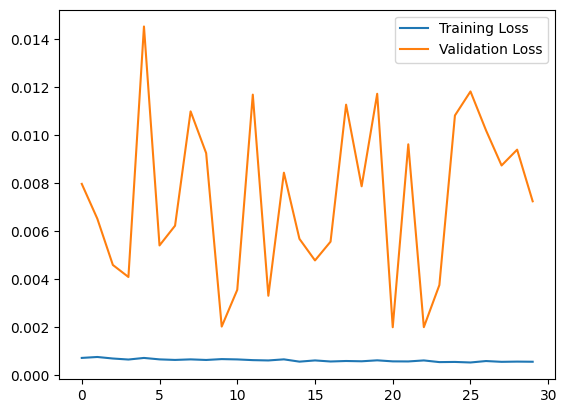

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Optionally, you can plot the training history to check for overfitting
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


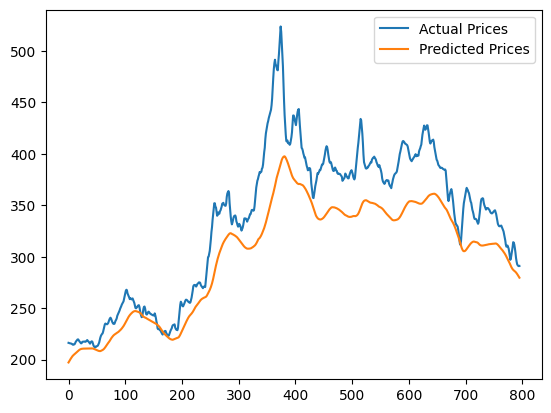

In [ ]:
# Predict the stock price on test data
y_pred = model.predict(X_test)

# Get the number of features used in the LSTM model
num_features = X_test.shape[2]

# Reshape to 2D for inverse_transform
X_test_2D = X_test[:, -1, :].reshape(-1, num_features)

# Create a dummy array with the correct number of features the scaler was fit on
dummy_array = np.zeros((X_test_2D.shape[0], len(selected_features))) # Use len(selected_features) instead of len(features)

# Fill the dummy array with the relevant features from X_test_2D
dummy_array[:, :num_features] = X_test_2D

# Now use inverse_transform on the dummy array
X_test_rescaled = scaler.inverse_transform(dummy_array)[:, :num_features]

# Rescale the predicted values and actual values by appending them to the features
y_pred_rescaled = scaler.inverse_transform(np.hstack((X_test_rescaled, y_pred.reshape(-1, 1))))[:, -1]

# Ensure y_test and y_pred have the same length for rescaling
y_test_rescaled = scaler.inverse_transform(np.hstack((X_test_rescaled, y_test[:len(y_pred)].reshape(-1, 1))))[:, -1]

# Plot the actual vs predicted values
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.legend()
plt.show()

# **Hybrid LSTM+XGBoost**
**LSTM: Forecasts future market trends — for example, predicting future close prices, returns, or price directions.**  
**XGBoost: Takes the LSTM prediction (and maybe other features) as input, and classifies what action to take: Buy, Sell, or Hold**

In [ ]:
# Construct DataFrame for XGBoost
lstm_predicted_returns = np.append([0], np.diff(y_pred_rescaled) / y_pred_rescaled[:-1])

xgb_features = pd.DataFrame({
    "lstm_pred_return": lstm_predicted_returns.flatten(),  # can add other engineered features
    "hmm_state": df["hmm_state"].values[:len(lstm_predicted_returns.flatten())]  # Trim to length of lstm_predicted_returns
})

# Define target again (Buy/Sell/Hold)
threshold = 0.005
target = np.zeros_like(lstm_predicted_returns.flatten())
target[lstm_predicted_returns.flatten() > threshold] = 1   # Buy
target[lstm_predicted_returns.flatten() < -threshold] = -1 # Sell


In [ ]:
label_map = {-1: 0, 0: 1, 1: 2}
target_mapped = pd.Series(target).map(label_map)


In [ ]:
from xgboost import XGBClassifier

# Assuming you want to keep num_class=3, adjust the target mapping
label_map = {-1: 0, 0: 1, 1: 2}  # Ensure all classes [0, 1, 2] are present
target_mapped = pd.Series(target).map(label_map)

# Check if all classes are present in the target variable
unique_classes = target_mapped.unique()
expected_classes = np.arange(3)  # [0, 1, 2] for num_class=3

if len(unique_classes) < 3:  # If there are fewer than 3 unique classes
    # Handle imbalanced classes - We'll use a binary classification approach
    # Change objective to 'binary:logistic' for binary classification
    objective = 'binary:logistic'

    # Since we only have 2 classes, change num_class to 2 or remove it
    num_class = 2  # Or remove num_class parameter entirely

    # Modify the label_map to handle the two existing classes:
    label_map = {0: 0, 1: 1, 2: 1}  # Maps both buy(2) and hold(1) to 1
    target_mapped = pd.Series(target).map(label_map)
else:  # If all 3 classes are present
    # Use multiclass classification
    objective = 'multi:softmax'
    num_class = 3

# Ensure target_mapped and xgb_features have the same length
target_mapped = target_mapped[:len(xgb_features)]

model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective=objective,  # Use the appropriate objective
    # num_class=num_class,  # Use the appropriate num_class # num_class is automatically inferred for binary classification
    random_state=42
)

model_xgb.fit(xgb_features, target_mapped)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

# **Test Signal**

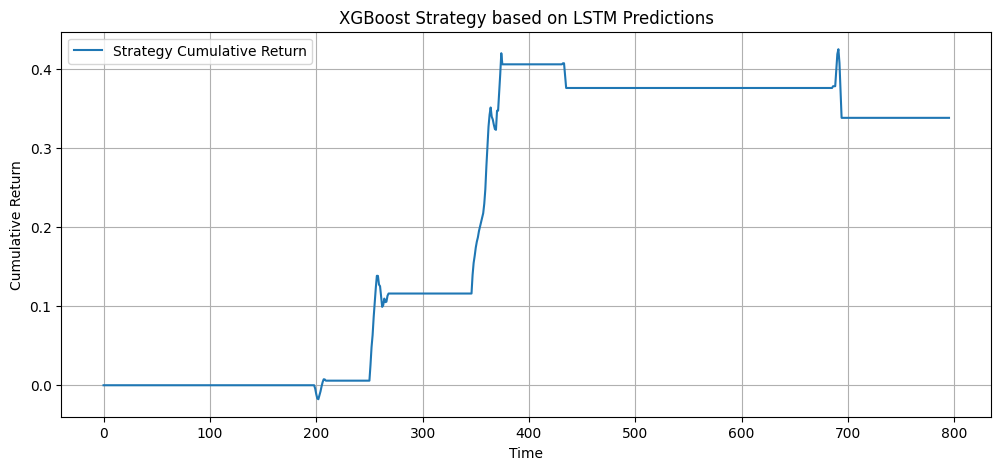

Sharpe Ratio: 1.73
Max Drawdown: -6.09%
Trading Frequency: 8.42% (~21.2 trades/year)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

# --- Step 1: Predict with XGBoost model ---
predictions = model_xgb.predict(xgb_features)

# --- Step 2: Remap prediction labels ---
# You used label_map = {-1: 0, 0: 1, 1: 2}
inverse_label_map = {0: -1, 1: 0, 2: 1}
signals = np.vectorize(inverse_label_map.get)(predictions)

# --- Step 3: Calculate strategy returns based on predicted signals ---
# Get the actual test returns
actual_returns = np.append([0], np.diff(y_test_rescaled) / y_test_rescaled[:-1])

# Make sure lengths match
signals = signals[:len(actual_returns)]

# Shift signal so that we execute at the next timestep
shifted_signals = np.roll(signals, 1)
shifted_signals[0] = 0  # Neutral at the start

strategy_returns = shifted_signals * actual_returns

# --- Step 4: Compute metrics ---

# Cumulative returns
cumulative_returns = np.cumprod(1 + strategy_returns) - 1

# Sharpe Ratio
sharpe_ratio = np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-9) * np.sqrt(252)

# Max Drawdown
cumulative_curve = (1 + strategy_returns).cumprod()
rolling_max = np.maximum.accumulate(cumulative_curve)
drawdown = cumulative_curve / rolling_max - 1
max_drawdown = drawdown.min()

# Trading Frequency
trading_actions = np.count_nonzero(shifted_signals)
trading_frequency = trading_actions / len(shifted_signals)
trades_per_year = trading_frequency * 252

# --- Step 5: Plot ---
plt.figure(figsize=(12,5))
plt.plot(cumulative_returns, label='Strategy Cumulative Return')
plt.title("XGBoost Strategy based on LSTM Predictions")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

# --- Step 6: Print Results ---
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Trading Frequency: {trading_frequency:.2%} (~{trades_per_year:.1f} trades/year)")
